In [1]:
# Imports and settings
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
from   sqlalchemy import *

sns.set(context='talk')

# Postgres server info
postgres_credentials = '/Users/mwilkens/Google Drive/Private/postgresql-96-credentials.txt'
postgres_server      = 'localhost'
postgres_db_name     = 'research'
postgres_port        = '5433'

# File locations
data_dir = 'datasets'
metadata_old_file = os.path.join(data_dir, 'pre23_corrected_metadata.csv.gz')
metadata_new_file = os.path.join(data_dir, 'post22_corrected_metadata.csv.gz')
gender_old_file   = os.path.join(data_dir, 'pre23_character_data.csv.gz')
gender_new_file   = os.path.join(data_dir, 'post22_character_data.csv.gz')

## Metadata

In [2]:
# Read Pre-1923 metadata
meta_old = pd.read_csv(
    metadata_old_file,
    compression='gzip'
)

# Standardize data format
meta_old.drop(['recordid'], axis=1, inplace=True)
meta_old.rename({'volid':'htid'}, axis='columns', inplace=True)
meta_old.enumcron.replace('<blank>', np.nan, inplace=True)

# Read 1923+ metadata
meta_new = pd.read_csv(
    metadata_new_file,
    compression='gzip'
)

# Standardize format
meta_new.drop(['recordid'], axis=1, inplace=True)
meta_new.rename({'storyid':'htid'}, axis='columns', inplace=True)

# Combine and drop duplicates
metadata = meta_old.append(meta_new)
metadata.drop_duplicates(subset=['docid', 'htid'], inplace=True)
metadata.to_csv(
    os.path.join(data_dir, 'metadata.csv.gz'),
    compression='gzip',
    index=False
)
display(metadata.head())
print('Metadata entries:', metadata.shape[0])

,docid,htid,author,firstname,inferreddate,birthdate,authgender,enumcron,title
0,10610,uva.x030803549,"Livingston, Margaret Vere F.",NaN,1888,NaN,f,NaN,Tales of King Arthur and his knights of the Ro...
1,12455,njp.32101068142262,"Livingston, Margaret Vere Farrington,",NaN,1890,NaN,f,NaN,Fra Lippo Lippi
2,6360,nyp.33433076024185,"Loughead, Flora Haines.",NaN,1898,NaN,f,NaN,The black curtain
3,6361,nyp.33433076024177,"Loughead, Flora Haines Apponyi,",NaN,1886,NaN,f,NaN,The man who was guilty
4,11987,uc1.b4102046,"Loughead, Flora Haines.",NaN,1891,NaN,f,NaN,The abandoned claim


Metadata entries: 95486


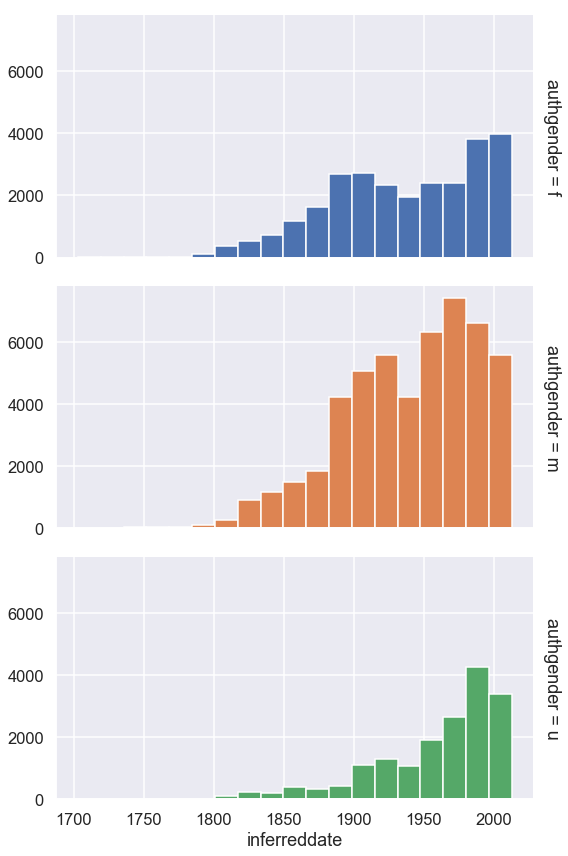

In [3]:
# Plot metadata corpus shape by gender
g = sns.FacetGrid(
    metadata, 
    row='authgender', 
    hue='authgender', 
    margin_titles=True,
    height=4,
    aspect=2
)
bins = np.linspace(metadata.inferreddate.min(), metadata.inferreddate.max(), 20)
g.map(plt.hist, 'inferreddate', bins=bins);

## Gender data

In [2]:
gender_old = pd.read_csv(
    gender_old_file,
    compression='gzip'
)
gender_new = pd.read_csv(
    gender_new_file,
    compression='gzip'
)
gender = gender_old.append(gender_new)
gender.to_csv(
    os.path.join(data_dir, 'gender.csv.gz'),
    compression='gzip',
    index=False
)
display(gender.head())
print("Unique volumes:", gender.docid.nunique())

,docid,date,gender,role,count
0,9709,1871,u,characters,7
1,9709,1871,u,agent,7
2,9709,1871,u,mod,0
3,9709,1871,u,patient,1
4,9709,1871,u,poss,0


Unique volumes: 134335


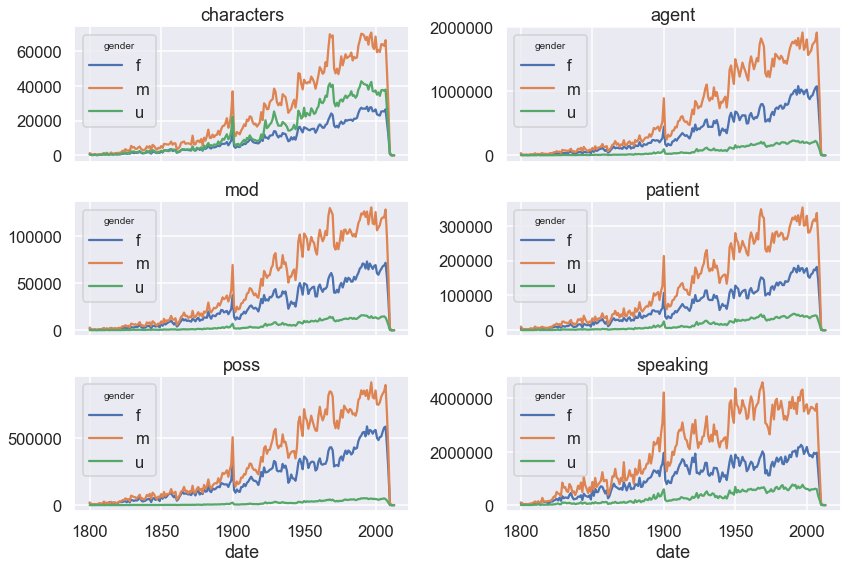

In [28]:
# Plot gender role counts by type and year
roles = gender.role.unique()
fig, axes = plt.subplots(3, 2, sharex=True, sharey=False, figsize=(12,8))
row = 0
col = 0
i = 0
for role in roles:
    g = gender.loc[(gender.date>=1800) & (gender.role==role)].groupby(['date', 'gender'])
    g.sum()['count'].unstack().plot(ax=axes[row,col])
    axes[row, col].set_title(role)
    i += 1
    if i in [2,4]:
        row = i//2
    if i%2 >0:
        col = 1
    else:
        col = 0
plt.tight_layout()
plt.show()

## Geo data

### Set up Postgres connection

This is needed if interacting with the database that stores geo data and metadata. Required for full processing, but can often skip is just tweaking an existing run. Requires a network connection, SSH, proper SQLAlchemy imports (above). Need SSH tunnel in place first.

In [3]:
# Get credentials from file
try:
    pg_username, pg_password = open(postgres_credentials).read().strip().split(' ')
except:
    sys.exit('Cannot get Postgres credentials. Exiting.')
    
# Set up engine and connect
try:
    pg_engine_string = 'postgresql+psycopg2://'+pg_username+':'+pg_password+'@'+postgres_server+':'+postgres_port+'/'+postgres_db_name
    pg_engine = create_engine(pg_engine_string, echo=False, use_batch_mode=True)
    pg_metadata = MetaData()
    pg_conn = pg_engine.connect()
    print("Postgres connection established.")
except:
    sys.exit('Cannot make initial connection to Postgres database. Aborting.')

Postgres connection established.


### Build results tables in Postgres

Do this in pure SQL in the database. See file `'BuildResults.sql'` for the code. Execute on DB server as:

```
/usr/pgsql-9.6/bin/psql -p 5433 -f ./BuildResults.sql research
```


### Read results table in from Postgres ...

In [7]:
# Read data from Postgres
geo = pd.read_sql_table('gender_results', pg_conn)

# Lowercase gender labels for uniformity
geo.gender = geo.gender.str.lower().replace('andy', 'androg')

# Write out to disk
geo.to_csv(os.path.join(data_dir, 'geo.tsv.gz'), sep='\t', index=False, compression='gzip')

### ... or load geo data from disk

In [7]:
geo = pd.read_csv(os.path.join(data_dir, 'geo.tsv.gz'), sep='\t', low_memory=False)

In [10]:
# Show a bit of data
display(geo.head())
print("Unique volumes:", geo.htid.nunique())
print("Column names:", geo.columns)

,corpus,htid,text_string,lang,occurs,author,title,pub_date,gender,genre,...,route,post_code,natural_feature,point_of_interest,colloquial_area,continent,other,lat,lon,wordcount
0,Hathi,uc1.32106010050240,100th street,en,1,"Ellroy, James",CLandestine / James Ellroy.,1984,male,Fiction,...,100th Street,50322,NaN,NaN,NaN,NaN,NaN,41.629257,-93.755830,137372
1,Hathi,mdp.49015002580182,110th street,en,1,NaN,The Oxford book of American short stories / ed...,1994,NaN,Fiction,...,110th Street,NaN,NaN,NaN,NaN,NaN,NaN,39.667364,-95.564081,363317
2,Hathi,uc1.32106002116355,110th street,en,1,"Himes, Chester B",The big gold dream [by] Chester Himes.,1968,male,Fiction,...,110th Street,NaN,NaN,NaN,NaN,NaN,NaN,39.667364,-95.564081,68744
3,Hathi,uc1.b4079824,110th street,en,1,"Wolfe, Thomas",Selections from the works of Thomas Wolfe. ed....,1952,male,Fiction,...,110th Street,NaN,NaN,NaN,NaN,NaN,NaN,39.667364,-95.564081,263612
4,Hathi,mdp.39015029554741,110th street,en,1,NaN,The Oxford book of American short stories / ed...,1992,NaN,Fiction,...,110th Street,NaN,NaN,NaN,NaN,NaN,NaN,39.667364,-95.564081,360224


Unique volumes: 47753
Column names: Index(['corpus', 'htid', 'text_string', 'lang', 'occurs', 'author', 'title',
       'pub_date', 'gender', 'genre', 'white', 'origin_area', 'origin_nation',
       'place_id', 'formatted_address', 'location_type', 'country_long',
       'country_short', 'admin_1_long', 'admin_1_short', 'admin_2', 'admin_3',
       'admin_4', 'admin_5', 'locality', 'sublocality_1', 'sublocality_2',
       'sublocality_3', 'neighborhood', 'premise', 'subpremise',
       'street_number', 'street_address', 'route', 'post_code',
       'natural_feature', 'point_of_interest', 'colloquial_area', 'continent',
       'other', 'lat', 'lon', 'wordcount'],
      dtype='object')


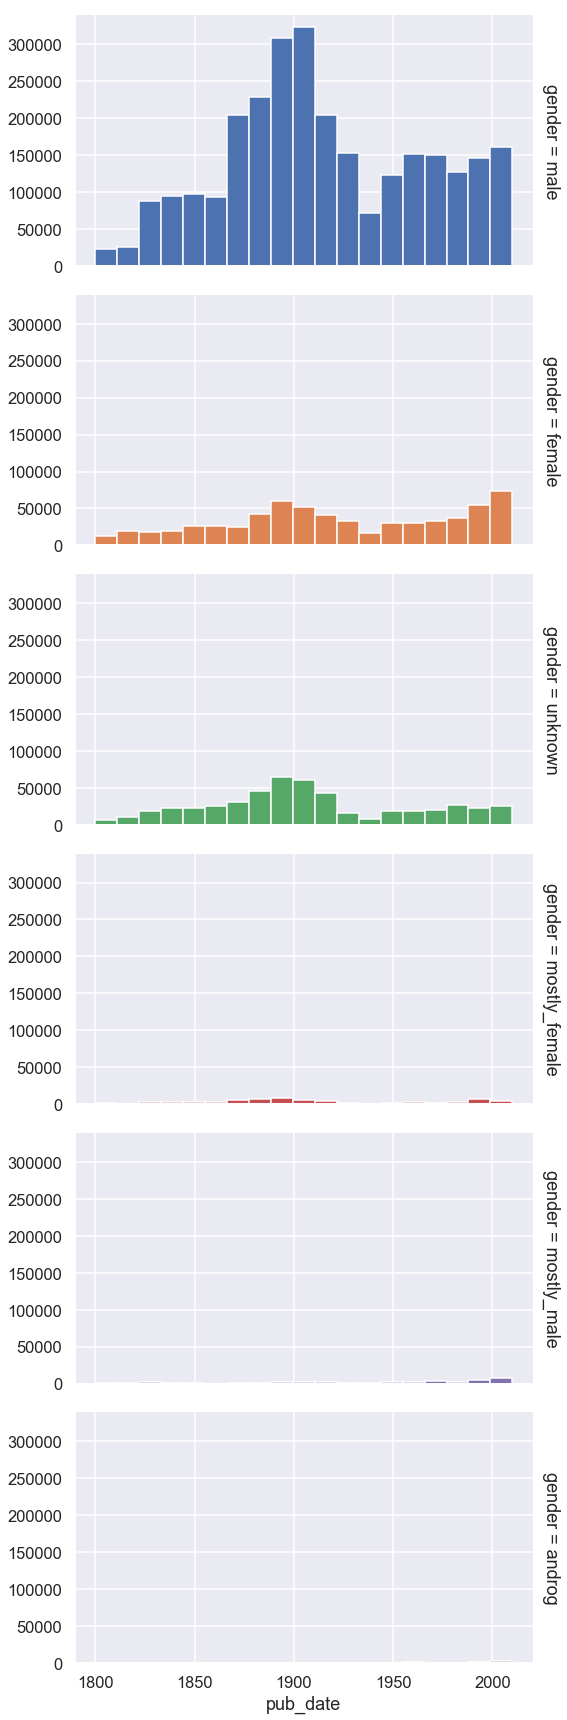

In [11]:
g = sns.FacetGrid(
    geo, 
    row='gender', 
    hue='gender', 
    margin_titles=True,
    height=4,
    aspect=2
)
bins = np.linspace(geo.pub_date.min(), geo.pub_date.max(), 20)
g.map(plt.hist, 'pub_date', bins=bins);